In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 100

# Toy Galaxy Model

In [3]:
import prfm
import numpy as np

## Model

As an example, we set up a simple galaxy model between R=2-16kpc. The gas and stellar surface densities are decreasing linearly and exponetially with radius, respectively. The stellar scale height is held fixed. A flat rotation curve is assumed so that $\Omega_d\propto R^{-1}$. 

**The parameters must be in c.g.s. units.**

In [4]:
# assuming conventional astro-friendly units
# [Sigma] = M_sun/pc^2
# [rho] = M_sun/pc^3
# [Omega] = km/s/kpc
# [H] = pc
# [R] = kpc
# [Sigma_SFR] = M_sun/kpc^2/yr
# [v] = km/s

# reference values at solar circle
Sigma_gas = 10
Sigma_star = 42
Omega_d = 28
H_star = 245

# radius array
R = np.linspace(2, 16, 100)
R0 = 8
Re = 3.5

r0 = R / R0
re = R / Re

# construct radial profile array
Sigma_gas = Sigma_gas / r0  # linear in R
Sigma_star = Sigma_star * np.exp((R0 / Re) - re)  # exponeital disk
Omega_d = Omega_d / r0  # flat rotation curve
H_star = H_star  # no flaring
sigma_eff = 15  # constant sigma_eff=15km/s

In [5]:
# construct model
# parameters are given in astro-friendly units
mymodel = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff=sigma_eff,
    astro_units=True,
)

The class input parameters must contain
* Sigma_gas
* two of three stellar disk parameters: `Sigma_star`, `H_star`, `rho_star`
  * the rest will be calculated using `Sigma_star = 2*rho_star*H_star`
  * if only `Sigma_star` is provided, it will assume a razor-thin stellar disk (not implemented)
  * if only `rho_star` is provided, it will assume a thick stellar disk (not implemented)
  * if none of these are provided, it will assume no stellar disk (i.e., `Sigma_star=0`)
* one of two dark matter halo parameters: `Omega_d` or `rho_dm`
  * two are connected by assuming a flat rotation curve `rho_dm = Omega_d**2/(4*pi*G)`
  * if none of these are provided, it will assume no dark matter halo (i.e., `rho_star=0`)

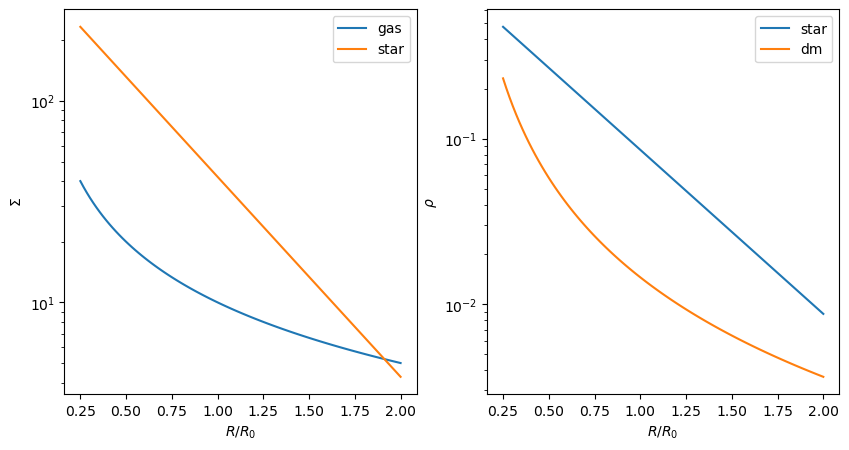

In [6]:
# model profiles
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(r0, mymodel.Sigma_gas, label="gas")
plt.plot(r0, mymodel.Sigma_star, label="star")
plt.ylabel(r"$\Sigma$")
plt.xlabel(r"$R/R_0$")
plt.legend()
plt.yscale("log")

plt.subplot(122)
plt.plot(r0, mymodel.rho_star, label="star")
plt.plot(r0, mymodel.rho_dm, label="dm")
plt.ylabel(r"$\rho$")
plt.xlabel(r"$R/R_0$")
plt.legend()
plt.yscale("log")

## Test vertical equilibrium solutions

The gas scale heights can be calculated either analytically or numerically. The `PRFM.get_scale_height` class method provides a convenient wrapper for either case; simply call different function depending on `method=["analytic", "numerical"]`. Internally, functions below will be called.

* `get_scale_height_analytic` provides an analytic solution of the cubic equation for a given parameter set.
    * `get_scale_height_[gas,star,dm]_only` provides an anlytic solution when only weight from the selected component is considered.
    * `get_scale_height_star_gas` provides an analytic solution when the dark matter contribution is neglected.
    * `get_scale_height_dm_gas` provides an analytic solution when the stellar contribution is neglected.
* `get_scale_height_numerical` provides a numerical solution for a given parameter set. Each weight term can be turned on and off by setting e.g., `wgas=1` or `wgas=0`.

In the examples below, we assume a constant `sigma_eff` and check consistency between numerical and analytic solutions.

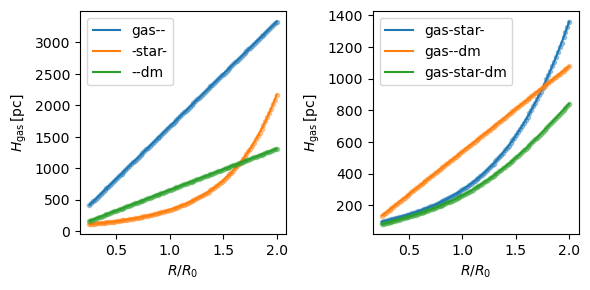

In [7]:
# sanity checks
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

labels = ["gas", "star", "dm"]
# gas, star, dm only scale heights
plt.sca(axes[0])
for wgas, wstar, wdm in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]:
    H_ana = mymodel.get_scale_height(method="analytic", wgas=wgas, wstar=wstar, wdm=wdm)
    H_num = mymodel.get_scale_height(
        method="numerical", wgas=wgas, wstar=wstar, wdm=wdm
    )
    label = "-".join(
        [l if w_ == 1 else "" for w_, l in zip((wgas, wstar, wdm), labels)]
    )
    (l,) = plt.plot(r0, H_ana, label=label)
    plt.plot(r0, H_num, ".", color=l.get_color(), alpha=0.4)
plt.ylabel(r"$H_{\rm gas}\,[{\rm pc}]$")
plt.xlabel(r"$R/R_0$")
plt.legend()

# star-gas, dm-gas, and full scale heights
plt.sca(axes[1])
for wgas, wstar, wdm in [[1, 1, 0], [1, 0, 1], [1, 1, 1]]:
    H_ana = mymodel.get_scale_height(method="analytic", wgas=wgas, wstar=wstar, wdm=wdm)
    H_num = mymodel.get_scale_height(
        method="numerical", wgas=wgas, wstar=wstar, wdm=wdm
    )
    label = "-".join(
        [l if w_ == 1 else "" for w_, l in zip((wgas, wstar, wdm), labels)]
    )

    (l,) = plt.plot(r0, H_ana, label=label)
    plt.plot(r0, H_num, ".", color=l.get_color(), alpha=0.4)
plt.ylabel(r"$H_{\rm gas}\,[{\rm pc}]$")
plt.xlabel(r"$R/R_0$")
plt.legend()
plt.tight_layout()

There are additional convenient function wrappers (internally using `PRFM.get_scale_height` to find gas scale height):
* `PRFM.calc_weights`: calculate $H_{\rm gas}$, $\cal{W}_{\rm gas}$, $\cal{W}_*$, and $\cal{W}_{\rm dm}$ and store them to attributes `H_gas`, `Wgas`, `Wstar`, `Wdm` as well as `Wtot` and `sigma_eff` if it assumes a model.
* `PRFM.get_weight_contribution`: returns $\cal{W}_{\rm gas}/\cal{W}_{\rm tot}$, $\cal{W}_*/\cal{W}_{\rm tot}$, and $\cal{W}_{\rm dm}/\cal{W}_{\rm tot}$ 

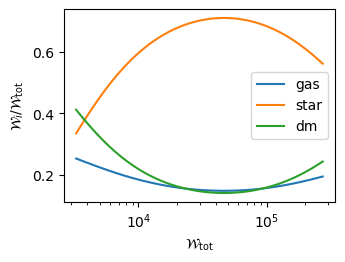

In [8]:
mymodel.calc_weights()
wfrac = mymodel.get_weight_contribution()
plt.figure(figsize=(3.5, 2.5))
plt.plot(mymodel.Wtot, wfrac[0], label="gas")
plt.plot(mymodel.Wtot, wfrac[1], label="star")
plt.plot(mymodel.Wtot, wfrac[2], label="dm")
plt.ylabel(r"$\mathcal{W}_i/\mathcal{W}_{\rm tot}$")
plt.xlabel(r"$\mathcal{W}_{\rm tot}$")
plt.xscale("log")
plt.legend()

## Self-consistent solutions for different velocity dispersion models

`PRFM.calc_self_consistent_solution` function will calculate the scale height, weight, and velocity dispersion iteratively for a given velocity dispersion model. 

`sigma_eff` can either be a constant or a string to specify a model. For now, we provide two velocity dispersion models `tigress-classic-mid` and `tigress-classic-avg`. Additional calibration results using the TIGRESS-NCR suite is available as `tigress-ncr-mid` and `tigress-ncr-avg`. For user-specfic velocity dispersion models using the same functional form, one can specify a coefficient, `sigma_0`, and a power-law exponent, `expo`, as well as the minimum veloicty dispersion, `sigma_min`. To allow additional metallicity dependence, one can specify `epxo_Z`.

(TODO)

```py
sigma_eff_models['custom']=dict(sigma_0 = 10, expo = 0.2, expo_Z=0.05, sigma_min=10)
```

Then, `sigma_eff="custom"` can be passed as a keyword for the function `calc_self_consistent_solution`

In [9]:
# setting up three models with different assumptions for the effective velocity disersion
const_model = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff=sigma_eff,
    astro_units=True,
)

tigress_mid_model = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff="tigress-classic-mid",
    astro_units=True,
)

tigress_avg_model = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff="tigress-classic-avg",
    astro_units=True,
)

Calculating analytic H and weight solutions using the constant effective EoS
Calculating analytic H and weight solutions using the tigress-classic-mid effective EoS
Calculating analytic H and weight solutions using the tigress-classic-avg effective EoS
Calculating numerical H and weight solutions using the constant effective EoS
Calculating numerical H and weight solutions using the tigress-classic-mid effective EoS
Calculating numerical H and weight solutions using the tigress-classic-avg effective EoS


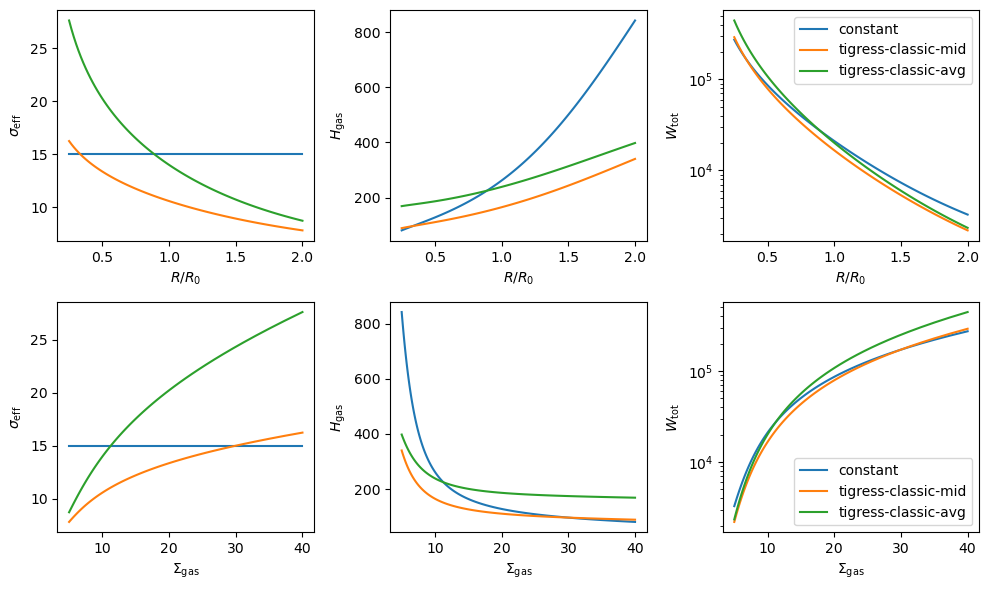

In [10]:
fig, axes_ = plt.subplots(2, 3, figsize=(10, 6))
axes = axes_[0, :]
for m in [const_model, tigress_mid_model, tigress_avg_model]:
    m.calc_self_consistent_solution()
    label = m.name
    for y, ax in zip([m.sigma_eff, m.H_gas, m.Wtot], axes):
        plt.sca(ax)
        plt.plot(r0, y * np.ones_like(r0), label=label)
xlab = r"$R/R_0$"
ylabels = [r"$\sigma_{\rm eff}$", r"$H_{\rm gas}$", r"$W_{\rm tot}$"]
for ax, ylab in zip(axes, ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale("log")
# plt.xscale('log')
plt.legend()

axes = axes_[1, :]
for m in [const_model, tigress_mid_model, tigress_avg_model]:
    m.calc_self_consistent_solution(method="numerical")
    label = m.name
    for y, ax in zip([m.sigma_eff, m.H_gas, m.Wtot], axes):
        plt.sca(ax)
        plt.plot(m.Sigma_gas, y * np.ones_like(r0), label=label)
xlab = r"$\Sigma_{\rm gas}$"
ylabels = [r"$\sigma_{\rm eff}$", r"$H_{\rm gas}$", r"$W_{\rm tot}$"]
for ax, ylab in zip(axes, ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale("log")
# plt.xscale('log')
plt.legend()
plt.tight_layout()

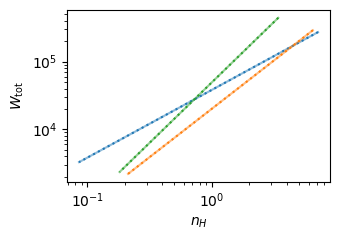

In [11]:
# sanity check for effective EOS
import astropy.constants as ac

fig = plt.figure(figsize=(3.5, 2.5))
ax = plt.subplot(111)
for m in [const_model, tigress_mid_model, tigress_avg_model]:
    rho_gas = m._Sigma_gas / (2 * m._H_gas)
    nH = rho_gas / (1.4 * ac.m_p.cgs.value)
    label = m.name

    (l,) = plt.plot(nH, m.Wtot, alpha=0.5, label=label)
    if m._sigma_eff_model != "constant":
        seff = prfm.get_sigma_eff(m._Wtot, model=m._sigma_eff_model)
    else:
        seff = m._sigma_eff
    plt.plot(
        nH, rho_gas * seff**2 / m.units["Wtot"].cgs.value, color=l.get_color(), ls=":"
    )

plt.sca(ax)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$n_H$")
plt.ylabel(r"$W_{\rm tot}$")
# plt.xscale('log')
plt.tight_layout()

## SFR surface density

Finally, SFR surface density can be calculated by the formula `Sigma_SFR = P_tot/Y_tot = W_tot/Y_tot`, where `Y_tot` is the total feedback yield. One can use a constant value or array for `Ytot` or pass a model string among [`tigress-classic`, `tigress-classic-decomp`, `tigress-ncr`, `tigress-ncr-decomp`, `tigress-ncr-decomp-all`]. 

Calculating Sigma_SFR with the tigress-classic feedback yield model
Calculating Sigma_SFR with the tigress-classic feedback yield model
Calculating Sigma_SFR with the tigress-classic feedback yield model


Text(0, 0.5, '$\\Sigma_{\\rm SFR}\\, [M_\\odot\\,{\\rm kpc^{-2}\\,yr^{-1}}]$')

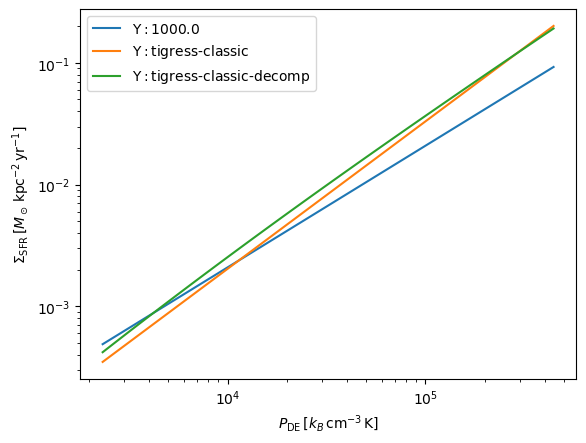

In [12]:
# Pressure-Sigma_SFR relation
for y in [1.0e3, "tigress-classic", "tigress-classic-decomp"]:
    tigress_avg_model.calc_sfr(Ytot=y)
    plt.plot(
        tigress_avg_model.Wtot,
        tigress_avg_model.Sigma_SFR,
        label=r"$\Upsilon:$" + "{}".format(y),
    )
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$P_{\rm DE}\, [k_B{\rm\,cm^{-3}\,K}]$")
plt.ylabel(r"$\Sigma_{\rm SFR}\, [M_\odot\,{\rm kpc^{-2}\,yr^{-1}}]$")